In [1]:
import pickle
import os
import collections

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from tqdm import tqdm
from transformers import BertTokenizer
import matplotlib.pyplot

from utils import load_obj_tsv

TINY_IMG_NUM = 512
FAST_IMG_NUM = 5000

VQA_DATA_ROOT = '/home/u37216/data/vqa/'
MSCOCO_IMGFEAT_ROOT = '/home/u37216/data/mscoco_imgfeat/'
load_lxmert_qa_path = '/home/u37216/snap/pretrained/model'
#'/home/jupyter/vcr/lxmert/data/mscoco_imgfeat/'
SPLIT2NAME = {
    'train': 'train2014',
    'valid': 'val2014',
    'minival': 'val2014',
    'nominival': 'val2014',
    'test': 'test2015',
}
torch.cuda.is_available()

I0127 00:45:22.495327 140679307803520 file_utils.py:35] PyTorch version 1.4.0+cpu available.
/glob/intel-python/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


False

In [2]:
from optimizers.lamb import Lamb

In [3]:
train='train'
valid='valid'
test=None
bs=128
lr=1e-4
epochs=10
dpt=0.1
seed=9595
output_dir='test'
fast=False
tiny=False
load=None
load_lxmert=None
load_lxmert_qa=None
from_scratch=False
mce_loss=False
llayers=9
xlayers = 5
rlayers=5
taskMatched = False
taskMaskLM=False
taskObjPredict=False
taskQA=False
visualLosses='obj,attr,feat'
qaSets=None
wordMaskRate=0.15 
objMaskRate=0.15
multiGPU=False
num_workers=4  

In [4]:
from dataset.vqa import VQADataset,VQATorchDataset, VQAEvaluator

In [5]:
DataTuple = collections.namedtuple("DataTuple", 'dataset loader evaluator')

def get_data_tuple(path: str, mscoco_path: str, splits: str, tiny: bool,bs:int, shuffle=False, drop_last=False) -> DataTuple:
    dset = VQADataset(path,splits)
    tset = VQATorchDataset(dset,mscoco_path,tiny)
    evaluator = VQAEvaluator(dset)
    data_loader = DataLoader(
        tset, batch_size=bs,
        shuffle=shuffle, num_workers=8,
        drop_last=drop_last, pin_memory=True
    )

    return DataTuple(dataset=dset, loader=data_loader, evaluator=evaluator)

In [6]:
# VQA_DATA_ROOT = '/home/u37216/data/vqa/'
# dset_train_init = VQADataset(VQA_DATA_ROOT,'minival') #'train,nominival'
# dset_valid_init = VQADataset(VQA_DATA_ROOT,'minival')

In [7]:
train_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT, 'minival', True, 32,True,False)
 #'train,nominival'
valid_tuple = get_data_tuple(VQA_DATA_ROOT, MSCOCO_IMGFEAT_ROOT,'minival',True,32,True,False)

4it [00:00, 37.85it/s]

Load 25994 data from split(s) minival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


496it [00:02, 174.14it/s]
0it [00:00, ?it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2546 data in torch dataset

Load 25994 data from split(s) minival.
Start to load Faster-RCNN detected objects from /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv


490it [00:02, 177.59it/s]

Loaded 500 images in file /home/u37216/data/mscoco_imgfeat/val2014_obj36.tsv in 2 seconds.
Use 2546 data in torch dataset



Plotting from  /home/u37216/data/vqa/minival2014/COCO_val2014_000000393267.jpg


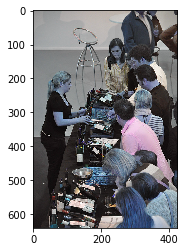

(None,
 {'answer_type': 'other',
  'img_id': 'COCO_val2014_000000393267',
  'label': {'fashion': 0.3, 'style': 0.3, "they aren't": 0.3},
  'question_id': 393267002,
  'question_type': 'why',
  'sent': 'Why are some people wearing hats?'})

In [8]:
train_tuple[0].plot_img(2)

In [9]:
from pretrain.qa_answer_table import load_lxmert_qa
from lxrt.entry import LXRTEncoder
from activation import GeLU
from transformers.modeling_bert import BertLayerNorm

In [10]:
class Args():
    def __init__(self,l_layers,x_layers,r_layers):
        self.llayers = l_layers
        self.xlayers = x_layers
        self.rlayers = r_layers
        self.from_scratch=False
args = Args(9,5,5)

In [11]:
#from tasks.vqa_model import VQAModel
from models.lxrt_adaptive import VQAModel_Adaptive

In [23]:
params = {'adapt_span_enabled': True, 'attn_span': 1024, 'adapt_span_loss_coeff': 0.000005, 'adapt_span_ramp': 32, 'adapt_span_init': 0.002, 'adapt_span_cache': True, 'nb_heads': 12,'bs': 256, 'mask_size': [20,36], 'sparse_enabled': True, 'num_attention_heads': 4, 'layer_sizes': {'lang':6,'cross':4,'vision':4}, 'from_scratch': False }

In [20]:
#model = VQAModel(train_tuple[0].num_answers,args)

In [24]:
model = VQAModel_Adaptive(train_tuple[0].num_answers,params)

I0127 00:47:03.634889 140679307803520 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/u37216/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0127 00:47:04.001823 140679307803520 lxmert_utils.py:200] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0127 00:47:04.004899 140679307803520 lxmert_utils.py:208] extracting archive file /home/u37216/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /home/u37216/tmp/tmpdskvqygi
I0127 00:47:11.813758 140679

LXRT encoder with 6 l_layers, 4 x_layers, and 4 r_layers.
Using Adaptive Variant
Sparse Enabled


In [25]:
from pretrain.qa_answer_table import load_lxmert_qa #,AnswerTable

In [26]:
#load_lxmert_qa(load_lxmert_qa_path, model, label2ans= train_tuple[0].label2ans)

In [27]:
class Learner():
    def __init__(self, model, train_tuple, val_tuple):
        self.model = model
        self.criterion = nn.BCEWithLogitsLoss()
        self.optim = Lamb(params=self.model.parameters(),lr=1e-4, weight_decay=1.2e-6, min_trust=0.25)  
        self.train_tuple = train_tuple
        self.val_tuple = val_tuple
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.output = 'snapshots/'
        os.makedirs(self.output, exist_ok=True)
        self.model.to(self.device)
        
        load_lxmert_qa(load_lxmert_qa_path, self.model, label2ans= self.train_tuple[0].label2ans)
        
    def train(self,num_epochs):
        dset, loader, evaluator = self.train_tuple
        best_valid = 0.
        iter_wrapper = (lambda x: tqdm(x, total=len(loader))) if args.tqdm else (lambda x: x)

        for epoch in range(num_epochs):
            quesid2ans = {}
            for i, (ques_id, feats, boxes, sent, target) in iter_wrapper(enumerate(loader)):
                self.model.train()
                self.optim.zero_grad()
                feats, boxes, target = feats.to(self.device), boxes.to(self.device), target.to(self.device)
                logit = self.model(feats,boxes,sent)
                assert logit.dim() == target.dim() == 2
                loss = self.criterion(logit,target)*logit.size(1)
                
                adapt_span_loss = 0.
                for l in self.model.encoder.layer:
                    adapt_span_loss += l.attention.self.adaptive_span.get_loss()
                    print(adapt_span_loss)
                loss += adapt_span_loss
                loss.backward()
                
                nn.utils.clip_grad_norm_(self.model.parameters(), 5.)
                self.optim.step()
                
                score, label = logit.max(1)
                for qid, l in zip(ques_id, label.cpu().numpy()):
                    ans = dset.label2ans[l]
                    quesid2ans[qid.item()] = ans
                    
                for l in self.model.encoder.layer:
                    l.attention.self.adaptive_span.clamp_param()
                
            log_str = "\nEpoch %d: Train %0.2f\n" % (epoch, evaluator.evaluate(quesid2ans) * 100.)

            if self.valid_tuple is not None:  # Do Validation
                valid_score = self.evaluate(eval_tuple)
                if valid_score > best_valid:
                    best_valid = valid_score
                    self.save("BEST")

                log_str += "Epoch %d: Valid %0.2f\n" % (epoch, valid_score * 100.) + \
                           "Epoch %d: Best %0.2f\n" % (epoch, best_valid * 100.)

            print(log_str, end='')

            with open(self.output + "/log.log", 'a') as f:
                f.write(log_str)
                f.flush()

        self.save("LAST")
    
    def predict(self, eval_dset, dump=None):
        """
        Predict the answers to questions in a data split.

        :param eval_tuple: The data tuple to be evaluated.
        :param dump: The path of saved file to dump results.
        :return: A dict of question_id to answer.
        """
        self.model.eval()
        dset, loader, evaluator = eval_tuple
        quesid2ans = {}
        for i, datum_tuple in enumerate(loader):
            ques_id, feats, boxes, sent = datum_tuple[:4]   # Avoid seeing ground truth
            with torch.no_grad():
                # feats, boxes = feats.cuda(), boxes.cuda()
                logit = self.model(feats, boxes, sent)
                score, label = logit.max(1)
                for qid, l in zip(ques_id, label.cpu().numpy()):
                    ans = dset.label2ans[l]
                    quesid2ans[qid.item()] = ans
        if dump is not None:
            evaluator.dump_result(quesid2ans, dump)
        return quesid2ans
    
    def evaluate(self, eval_tuple: DataTuple, dump=None):
        """Evaluate all data in data_tuple."""
        quesid2ans = self.predict(eval_tuple, dump)
        return eval_tuple.evaluator.evaluate(quesid2ans)

    @staticmethod
    def oracle_score(data_loader):
        quesid2ans = {}
        for i, (ques_id, feats, boxes, sent, target) in enumerate(data_loader):
            _, label = target.max(1)
            for qid, l in zip(ques_id, label.cpu().numpy()):
                ans = dset.label2ans[l]
                quesid2ans[qid.item()] = ans
        return evaluator.evaluate(quesid2ans)

    def save(self, name):
        torch.save(self.model.state_dict(),
                   os.path.join(self.output, "%s.pth" % name))

    def load(self, path):
        print("Load model from %s" % path)
        state_dict = torch.load("%s.pth" % path)
        self.model.load_state_dict(state_dict)
        

In [28]:
learn = Learner(model,train_tuple,valid_tuple)

Load QA pre-trained LXMERT from /home/u37216/snap/pretrained/model 
Loaded 3124 answers from LXRTQA pre-training and 5 not

Keys don't exactly match


In [29]:
learn.optim.state

defaultdict(dict, {})

In [31]:
from torch.optim import AdamW

In [32]:
opt = AdamW(learn.model.parameters())

In [ ]:
learn.train(4)


0it [00:00, ?it/s]
1it [00:06,  6.54s/it]
2it [00:10,  5.82s/it]
3it [00:14,  5.12s/it]
4it [00:17,  4.54s/it]
5it [00:20,  4.00s/it]
6it [00:23,  3.68s/it]
7it [00:25,  3.38s/it]
8it [00:28,  3.17s/it]